## Multi Language Model

### Light Pre-processing

Since the core of the analysis and pre-processing of the data has already been done in the previous notebooks, here we want only to make a few minor checks and some "selection" on the data to use for training.
In particular:
- Check on duplicated titles and null values
- Selection of data based on a threshold per category: we want to keep the data balanced, so it's important to sample the titles with respect to the class with the least data


In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import warnings
import os
import sys
import matplotlib.pyplot as plt
import pathlib
import pickle

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

pd.options.display.max_columns = 500
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = 500
tqdm.pandas()
warnings.filterwarnings("ignore")

In [3]:
root_path = str(pathlib.Path(os.path.dirname(os.path.realpath("__file__"))).resolve())
data_path = os.path.join(root_path, "data")

In [4]:
TRAINING_FILE_NAME = "sample_training.csv"
EVAL_FILE_NAME = "sample_evaluation.csv"
LANGS = ["de", "pt", "en", "it"]

In [5]:
df = pd.read_csv(os.path.join(data_path, TRAINING_FILE_NAME))

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        600 non-null    object
 1   title     600 non-null    object
 2   category  600 non-null    object
 3   language  600 non-null    object
dtypes: object(4)
memory usage: 18.9+ KB


In [7]:
df.sample(5)

,id,title,category,language
503,982ef000cda2e29dfe836ef81ebbc28a,entfernter psychiatrischer kliniker lcsw lmsw cc lcpc,Medical,de
251,83fda126bee5092cd68eb2f2d5331819,california bank trust branch relationship banker san francisco ca,Finance,en
313,8894aac9f9c006b712d154245c05e455,oficina supervisora de catering,Food,pt
50,9fc0bd1a82b8182266657208a4664448,bi lingual spanish recruiter,Accounting,en
222,2a68c861a2a1269694b33f5d28c55881,financial restructuring associate,Finance,en


In [8]:
df = df.drop(df[df["title"].isna()].index)

In [9]:
len(df)

600

In [10]:
N_CATEGORIES = len(df.category.unique())

## Modeling

After a lot of tests and trials and errors, we came up with an encoder to create the embeddings of the titles that has high speed and good accuracy on capturing the context of a sentence/title: [Multilingual Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder-multilingual/3), downloadable from tensorflow hub.
The steps that we followed for creating and training our model are:

 1. Splitting data in train/test to evaluate performances and fine-tuning the hyperparameters
 2. Create the model architecture, that in this first phase receives as input the titles already encoded to embeddings:
	 - The structure is composed by few dense layers with the adding of dropout in order to avoid overfitting
	 - Optimizer: *adam*
	 - Loss: SparseCategorical Cross Entropy
3.  Training
4. Evaluation of performances on test data

After we got our fine-tuned model, we are ready to create a self-contained version of it, which is capable of receiving a raw title as input, processing and cleaning it and make the final prediction.
This is done by creating a new version of the model, starting from the previous one, and by adding:
- A new input layer for reading strings
- A pre-processing layer for cleaning the title
- The encoder layer
- The previous model
- A layer to format the final output based on our needs



In [11]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text

In [12]:
label_col = "category"

In [13]:
le = preprocessing.LabelEncoder()
le.fit(df[label_col].values)
df["label"] = le.transform(df[label_col])

In [14]:
df.sample(5)

,id,title,category,language,label
332,9522a31a2561c5481b037d1c0d72867b,chef dello stadio,Food,it,3
305,b0bb7b024da7748d6a6c0e5a4eda0394,traveling executive chef se minnesota,Food,en,3
419,e56091ec33c9aedb6be77dcd34752496,express service writer advisor,IT,en,4
467,0b0924deec1f8326f6838f8dae530137,ingegnere informatico capo palo alto ca,IT,it,4
351,37e682363e948c7ed325b199b01982b1,chef cuochi tutti i livelli,Food,it,3


In [15]:
batch_size = 100
title_column = "title"

In [16]:
model_url = "https://tfhub.dev/google/universal-sentence-encoder-multilingual/3"
sentence_encoder = hub.load(model_url)

Metal device set to: Apple M1


2022-04-28 15:21:52.957969: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-28 15:21:52.958062: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-04-28 15:21:55.098632: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-28 15:21:55.099174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [17]:
X = df[title_column].values
y = df["label"].values

In [18]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42, shuffle=True
)

In [19]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((540,), (60,), (540,), (60,))

In [20]:
class_names = le.classes_
labels_size = len(le.classes_)
batch_size = 64

In [21]:
encoder_url = "https://tfhub.dev/google/universal-sentence-encoder-multilingual/3"

In [22]:
with open(os.path.join(data_path, "custom_stopwords.txt")) as f:
    custom_stopwords = [line.rstrip() for line in f.readlines()]

with open(os.path.join(data_path, "to_replace.txt")) as f:
    patterns_to_remove = [line.rstrip() for line in f.readlines()]

In [23]:
@tf.keras.utils.register_keras_serializable()
def preprocess_text(input_data):
    cleaned = tf.strings.lower(input_data)
    cleaned = tf.strings.regex_replace(cleaned, r"\xa0", " ", replace_global=True)
    cleaned = tf.strings.regex_replace(cleaned, r"\&amp", " ", replace_global=True)
    cleaned = tf.strings.regex_replace(cleaned, r"<.*?>", " ", replace_global=True)
    cleaned = tf.strings.regex_replace(cleaned, r"\(.+?\)", " ", replace_global=True)
    cleaned = tf.strings.regex_replace(
        cleaned,
        r"\b(" + r"|".join(patterns_to_remove) + r")\b\s*",
        " ",
        replace_global=True,
    )
    cleaned = tf.strings.regex_replace(
        cleaned,
        r"\b(" + r"|".join(custom_stopwords) + r")\b\s*",
        " ",
        replace_global=True,
    )
    cleaned = tf.strings.regex_replace(
        cleaned, r"[!\"#$%&\'()*+,-.–\/:;<=>?@[\\\]\^_`{|}~]", " ", replace_global=True
    )
    cleaned = tf.strings.regex_replace(cleaned, r"\b\d+\b", " ", replace_global=True)
    cleaned = tf.strings.regex_replace(cleaned, r"\s+", " ", replace_global=True)
    return tf.strings.strip(cleaned)

In [24]:
model = tf.keras.Sequential(
    [
        # Input layer with job title
        tf.keras.Input(shape=(), dtype="string", name="input"),
        # Pre-processing layer with custom pre-processing function
        tf.keras.layers.Lambda(lambda title: preprocess_text(title), name="preprocess"),
        # Sentence embedding layer with the link to the encoder model
        hub.KerasLayer(encoder_url, trainable=False),
        # Classifier layers
        tf.keras.layers.Dense(256, activation="relu", name="dense_1"),
        tf.keras.layers.Dropout(0.1, name="dropout_1"),
        tf.keras.layers.Dense(128, activation="relu", name="dense_2"),
        tf.keras.layers.Dropout(0.1, name="dropout_2"),
        tf.keras.layers.Dense(64, activation="relu", name="dense_3"),
        tf.keras.layers.Dropout(0.1, name="dropout_3"),
        # Softmax output layer (n classes = N_CATEGORIES)
        tf.keras.layers.Dense(N_CATEGORIES, activation="softmax", name="output"),
    ]
)

2022-04-28 15:21:57.624844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [25]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [26]:
epochs = 5

In [27]:
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", mode="auto", patience=3, verbose=1
        ),
    ],
    batch_size=batch_size,
    verbose=1,
)

Epoch 1/5


2022-04-28 15:22:00.158590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - ETA: 0s - loss: 1.7589 - sparse_categorical_accuracy: 0.4130

2022-04-28 15:22:01.732987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 4s 183ms/step - loss: 1.7589 - sparse_categorical_accuracy: 0.4130 - val_loss: 1.6965 - val_sparse_categorical_accuracy: 0.7667
Epoch 2/5
9/9 [==============================] - 1s 115ms/step - loss: 1.6221 - sparse_categorical_accuracy: 0.7500 - val_loss: 1.5278 - val_sparse_categorical_accuracy: 0.8000
Epoch 3/5
9/9 [==============================] - 1s 104ms/step - loss: 1.4041 - sparse_categorical_accuracy: 0.7907 - val_loss: 1.2694 - val_sparse_categorical_accuracy: 0.8167
Epoch 4/5
9/9 [==============================] - 1s 87ms/step - loss: 1.1033 - sparse_categorical_accuracy: 0.8167 - val_loss: 0.9652 - val_sparse_categorical_accuracy: 0.8000
Epoch 5/5
9/9 [==============================] - 1s 134ms/step - loss: 0.8070 - sparse_categorical_accuracy: 0.8222 - val_loss: 0.7154 - val_sparse_categorical_accuracy: 0.8167


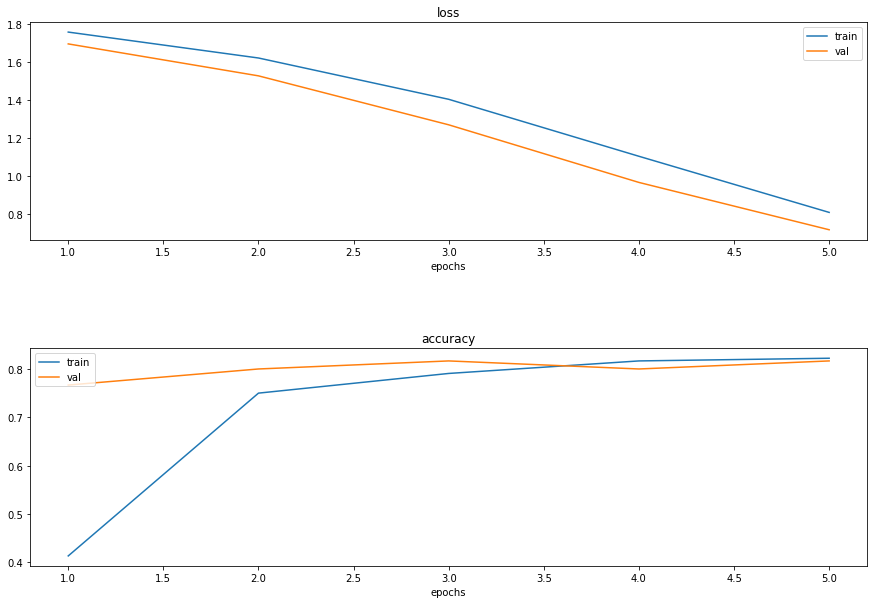

In [28]:
fig = plt.figure(figsize=(15, 10))

epochs = np.arange(1, len(history.history["loss"]) + 1, 1)

plt.subplot(2, 1, 1)
plt.plot(epochs, history.history["loss"], label="train")
plt.plot(epochs, history.history["val_loss"], label="val")
plt.title("loss")
plt.xlabel("epochs")
plt.ylabel("")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, history.history["sparse_categorical_accuracy"], label="train")
plt.plot(epochs, history.history["val_sparse_categorical_accuracy"], label="val")
plt.title("accuracy")
plt.xlabel("epochs")
plt.ylabel("")
plt.legend(loc="upper left")

fig.subplots_adjust(hspace=0.5)
# fig.savefig("data/pipeline/neural_network/training_history.png", dpi=300)
plt.show()

In [29]:
n = 50  # for 2 random indices
index_evaluation = np.random.choice(X_val.shape[0], n, replace=False)

In [30]:
# Evaluate the model
loss, acc = model.evaluate(X_val[index_evaluation], y_val[index_evaluation], verbose=2)
print("End to end model on evaluation dataset, accuracy: {:5.2f}%".format(100 * acc))

2/2 - 0s - loss: 0.7157 - sparse_categorical_accuracy: 0.8200 - 347ms/epoch - 174ms/step
End to end model on evaluation dataset, accuracy: 82.00%


In [31]:
test_sentences = ["software engineer", "data scientist", "chef"]

In [32]:
preds = model.predict(test_sentences)
labels = class_names[np.argmax(preds, axis=1)]
probs = np.amax(preds, axis=1)

2022-04-28 15:22:06.749444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [33]:
for test_sentence, prob, label in zip(test_sentences, probs, labels):
    print(test_sentence, prob, label)

software engineer 0.8844632 IT
data scientist 0.48573685 IT
chef 0.8599709 Food


### Save the model

Now that we have the final model, we can save it on disk and reload it when we need to perform further analysis or make predictions.


In [35]:
model_file_name = "sample_model"

In [36]:
tf.saved_model.save(
    model,
    os.path.join(data_path, model_file_name),
)

2022-04-28 15:22:08.952912: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-04-28 15:22:14.523940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: /Users/silvio/Documents/github/job-categorizer/data/sample_model/assets


INFO:tensorflow:Assets written to: /Users/silvio/Documents/github/job-categorizer/data/sample_model/assets


## Example for loading model from disk

In [37]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.saved_model.load(os.path.join(data_path, model_file_name))

2022-04-28 15:22:24.765057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [38]:
test_sentences = ["software engineer", "data scientist", "chef"]

In [39]:
preds = model(tf.constant(test_sentences, dtype=tf.string))
labels = class_names[np.argmax(preds, axis=1)]
probs = np.amax(preds, axis=1)

2022-04-28 15:22:24.969975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [40]:
for test_sentence, prob, label in zip(test_sentences, probs, labels):
    print(test_sentence, prob, label)

software engineer 0.8844632 IT
data scientist 0.48573685 IT
chef 0.8599709 Food


## Evaluation

In order to understand if the model is good, the best way is to test its performances on datasets that it has never seen. For this reason, we have created different datasets, each for a specific language, where there are mixed titles in terms of data cleanliness and category.

We have a model trained and capable of predicting titles for these languages: Arabic, Chinese-simplified, Chinese-traditional, English, French, German, Italian, Japanese, Korean, Dutch, Polish, Portuguese, Spanish, Thai, Turkish and Russian.

The accuracy tested on external evaluation data are: 

 - Italian - 705 titles: 84,146% 
 - English - 1954 titles: 89,94% 
 - German - 1693 titles: 84,803% 
 - Portuguese - 688 titles: 82,651% 
 - Polish - 688 titles: 78,191%
 - French - 1936 titles: 82,872%
 - Dutch - 1923 titles: 80,413%
 
 At `data/sample_evaluation.csv` you can find a sample of our multi-language evaluation dataset to test the model by yourself

#### Evaluating datasets with top-n accuracy

In [41]:
def top_n_accuracy(titles, categories, class_names, model, n=3):
    acc = 0
    preds = model(titles).numpy()
    top_n_idxs = np.argpartition(preds, kth=n, axis=1)[:, -n:]
    preds = np.take_along_axis(preds, top_n_idxs, axis=-1)
    top_n = np.take_along_axis(top_n_idxs, np.argsort(-preds), axis=-1)
    top_n_labels = class_names[top_n]
    for title, category, top_labels in zip(titles, categories, top_n_labels):
        if category in top_labels:
            acc += 1
    return int(round(acc / len(titles), 2) * 100)

In [42]:
langs = LANGS

In [43]:
eval_map = {lang: {} for lang in langs}

In [44]:
eval_df = pd.read_csv(os.path.join(data_path, EVAL_FILE_NAME))

In [45]:
eval_df = pd.read_csv(os.path.join(data_path, EVAL_FILE_NAME))
for n in [1, 3, 5]:
    for lang in langs:
        temp_eval_df = eval_df[eval_df["language"] == lang].copy()
        eval_map[lang][f"accuracy@{n}"] = top_n_accuracy(
            temp_eval_df["title"].values,
            temp_eval_df["category"].values,
            class_names,
            model,
            n=n,
        )
        print(lang, n, eval_map[lang][f"accuracy@{n}"])

2022-04-28 15:22:25.720756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


de 1 25


2022-04-28 15:22:26.551362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


pt 1 40


2022-04-28 15:22:27.442676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


en 1 42
it 1 40
de 3 100
pt 3 90
en 3 100
it 3 100
de 5 100
pt 5 100
en 5 100
it 5 100


In [46]:
complete_acc_df = pd.DataFrame(eval_map).T

In [47]:
complete_acc_df["lang"] = complete_acc_df.index

In [48]:
complete_acc_df

,accuracy@1,accuracy@3,accuracy@5,lang
de,25,100,100,de
pt,40,90,100,pt
en,42,100,100,en
it,40,100,100,it


In [49]:
complete_acc_df.to_csv(os.path.join(data_path, "sample_eval_map_top_n_accuracy.csv"))